# Load Libraries

In [1]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv
import pyet

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [2]:
# Load Data From Pickle
with open('../../data/Khorasan_Data_1950_2025.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531359 entries, 0 to 531358
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   station_id         531359 non-null  category      
 1   station_name       531359 non-null  category      
 2   region_id          531359 non-null  category      
 3   region_name        531359 non-null  category      
 4   lat                531359 non-null  float64       
 5   lon                531359 non-null  float64       
 6   station_elevation  531359 non-null  float64       
 7   date               531359 non-null  datetime64[ns]
 8   tmax               522466 non-null  float64       
 9   tmin               511502 non-null  float64       
 10  tm                 512414 non-null  float64       
 11  umax               394472 non-null  float64       
 12  umin               394447 non-null  float64       
 13  um                 394472 non-null  float64 

# Calculate ETo

#### Data Quality Control

In [4]:
def data_quality_control(
    df, 
    required_vars = ['tm']
):
    # Remove duplicates
    df = df[~df.duplicated(keep='first')]
    # Drop rows with missing essential variables
    df = df.dropna(subset=required_vars)
    # Clip or filter out physically impossible values (example thresholds, adjust as needed)
    if 'tm' in required_vars:
        df = df[(df['tm'] > -50) & (df['tm'] < 60)]
    if 'tmax' in required_vars:
        df = df[(df['tmax'] > -50) & (df['tmax'] < 70)]
    if 'tmin' in required_vars:
        df = df[(df['tmin'] > -60) & (df['tmin'] < 50)]
    if 'ffm' in required_vars:
        df = df[(df['ffm'] >= 0) & (df['ffm'] < 50)]
    if 'um' in required_vars:
        df = df[(df['um'] >= 0) & (df['um'] <= 100)]
    if 'umax' in required_vars:
        df = df[(df['umax'] >= 0) & (df['umax'] <= 100)]
    if 'umin' in required_vars:
        df = df[(df['umin'] >= 0) & (df['umin'] <= 100)]
    if 'sshn' in required_vars:
        df = df[(df['sshn'] >= 0) & (df['sshn'] <= 24)]
    return df

#### Calculate ETo

In [5]:

def calculate_eto_pm_fao56(group):
    print(f"Calculating ETo pm_fao56 for station {group.name}")
    group = data_quality_control(
        df=group, 
        required_vars=['tm', 'tmax', 'tmin', 'um', 'umin', 'umax', 'ffm', 'sshn', 'lat', 'station_elevation']
    )
    group = group.set_index('date').sort_index()

    # If group is empty after cleaning, return NaNs
    if group.empty:
        return pd.Series(np.nan, index=group.index)

    lat = pyet.utils.deg_to_rad(lat=group['lat'].iloc[0])
    elevation = group['station_elevation'].iloc[0]
    rs = pyet.calc_rad_sol_in(n=group['sshn'], lat=lat, as1=0.25, bs1=0.5, nn=None)    
    wind = group['ffm']
    tmean = group['tm']
    tmax = group["tmax"]
    tmin = group["tmin"]
    rh = group["um"]
    rhmax = group["umin"]
    rhmin = group["umax"]
    
    eto = pyet.pm_fao56(
        tmean=tmean,
        wind=wind,
        rs=rs,
        elevation=elevation,
        lat=lat,
        tmax=tmax,
        tmin=tmin,
        rh=rh,
        rhmax=rhmax,
        rhmin=rhmin
    )

    return eto


def calculate_eto_hargreaves(group):
    print(f"Calculating ETo hargreaves for station {group.name}")
    group = data_quality_control(
        df=group, 
        required_vars=['tm', 'tmax', 'tmin', 'lat']
    )
    group = group.set_index('date').sort_index()

    # If group is empty after cleaning, return NaNs
    if group.empty:
        return pd.Series(np.nan, index=group.index)

    lat = pyet.utils.deg_to_rad(lat=group['lat'].iloc[0])
    tmean = group['tm']
    tmax = group["tmax"]
    tmin = group["tmin"]
    
    eto = pyet.hargreaves(
        tmean=tmean,
        tmax=tmax,
        tmin=tmin,
        lat=lat,
        k=0.0135,
        method=0,
        clip_zero=True
    )

    return eto

eto_df_pm_fao56 = data.groupby(
    ['region_id', 'station_id'],
    group_keys=True
).apply(calculate_eto_pm_fao56)

eto_df_hargreaves = data.groupby(
    ['region_id', 'station_id'],
    group_keys=True
).apply(calculate_eto_hargreaves)

Calculating ETo pm_fao56 for station ('OIMB', '18535')
Calculating ETo pm_fao56 for station ('OIMB', '19003')
Calculating ETo pm_fao56 for station ('OIMB', '19041')
Calculating ETo pm_fao56 for station ('OIMB', '19062')
Calculating ETo pm_fao56 for station ('OIMB', '19125')
Calculating ETo pm_fao56 for station ('OIMB', '19178')
Calculating ETo pm_fao56 for station ('OIMB', '19180')
Calculating ETo pm_fao56 for station ('OIMB', '19261')
Calculating ETo pm_fao56 for station ('OIMB', '19262')
Calculating ETo pm_fao56 for station ('OIMB', '19263')
Calculating ETo pm_fao56 for station ('OIMB', '19394')
Calculating ETo pm_fao56 for station ('OIMB', '19516')
Calculating ETo pm_fao56 for station ('OIMB', '40791')
Calculating ETo pm_fao56 for station ('OIMB', '40792')
Calculating ETo pm_fao56 for station ('OIMB', '40793')
Calculating ETo pm_fao56 for station ('OIMB', '40809')
Calculating ETo pm_fao56 for station ('OIMB', '40827')
Calculating ETo pm_fao56 for station ('OIMB', '88150')
Calculatin

#### Join ETo with Original Data

In [6]:
if isinstance(eto_df_pm_fao56.index, pd.MultiIndex):
    eto_df_pm_fao56 = eto_df_pm_fao56.reset_index().rename(columns={0:'FAO56'})
    data = pd.merge(data, eto_df_pm_fao56, on=['region_id', 'station_id', 'date'], how='left')
else:
    data = data.join(eto_df_pm_fao56)

if isinstance(eto_df_hargreaves.index, pd.MultiIndex):
    eto_df_hargreaves = eto_df_hargreaves.reset_index().rename(columns={0:'Hargreaves'})
    data = pd.merge(data, eto_df_hargreaves, on=['region_id', 'station_id', 'date'], how='left')
else:
    data = data.join(eto_df_hargreaves)

data

,station_id,station_name,region_id,region_name,lat,lon,station_elevation,date,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,FAO56,Hargreaves
0,99436,Bajestan,OIMM,Khorasan Razavi,34.50,58.16,1293.00,2015-12-23 12:00:00,9.30,NaN,3.80,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN
1,99436,Bajestan,OIMM,Khorasan Razavi,34.50,58.16,1293.00,2015-12-24 12:00:00,8.90,0.60,5.40,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.05
2,99436,Bajestan,OIMM,Khorasan Razavi,34.50,58.16,1293.00,2015-12-25 12:00:00,7.10,3.00,5.10,NaN,NaN,NaN,1.25,NaN,NaN,NaN,0.73
3,99436,Bajestan,OIMM,Khorasan Razavi,34.50,58.16,1293.00,2015-12-26 12:00:00,9.80,3.80,5.10,NaN,NaN,NaN,1.75,NaN,NaN,NaN,0.88
4,99436,Bajestan,OIMM,Khorasan Razavi,34.50,58.16,1293.00,2015-12-27 12:00:00,10.00,-1.60,3.80,NaN,NaN,NaN,2.50,NaN,NaN,NaN,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531354,99448,Zahan,OIMB,South Khorasan,33.42,59.82,1714.00,2025-08-27 12:00:00,30.20,20.50,25.40,22.00,8.00,15.04,6.43,11.80,0.00,10.55,4.54
531355,99448,Zahan,OIMB,South Khorasan,33.42,59.82,1714.00,2025-08-28 12:00:00,30.20,20.50,25.40,20.00,9.00,14.90,6.35,11.80,0.00,10.54,4.52
531356,99448,Zahan,OIMB,South Khorasan,33.42,59.82,1714.00,2025-08-29 12:00:00,30.00,20.80,25.40,19.00,9.00,14.00,7.33,11.80,0.00,11.26,4.38
531357,99448,Zahan,OIMB,South Khorasan,33.42,59.82,1714.00,2025-08-30 12:00:00,30.10,21.00,25.50,25.00,11.00,17.29,6.14,11.80,0.00,10.12,4.35


#### Fill Missing Dates

In [7]:
# Fill missing dates for each station with NaN
all_dates = pd.date_range(data['date'].min(), data['date'].max(), freq='D')

def reindex_station(station_df):
    return station_df.set_index('date').reindex(all_dates).assign(
        region_id=station_df['region_id'].iloc[0],
        region_name=station_df['region_name'].iloc[0],
        station_id=station_df['station_id'].iloc[0],
        station_name=station_df['station_name'].iloc[0],
        station_elevation=station_df['station_elevation'].iloc[0],
        lat=station_df['lat'].iloc[0],
        lon=station_df['lon'].iloc[0],
    ).reset_index().rename(columns={'index': 'date'})

result = (
    data.groupby(['region_id', 'region_name', 'station_id', 'station_name', 'station_elevation', 'lat', 'lon'], group_keys=False)
    .apply(reindex_station)
    .reset_index(drop=True)
)

result

,date,station_id,station_name,region_id,region_name,lat,lon,station_elevation,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,FAO56,Hargreaves
0,1951-01-01 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1951-01-02 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1951-01-03 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1951-01-04 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1951-01-05 12:00:00,18535,Ghohestan,OIMB,South Khorasan,33.16,59.71,1984.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263571,2025-08-27 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,33.60,20.40,27.00,56.00,24.00,39.38,7.96,12.30,0.00,9.56,5.38
2263572,2025-08-28 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,35.50,21.40,28.50,56.00,16.00,38.92,6.75,11.70,0.00,9.61,5.73
2263573,2025-08-29 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,35.60,21.40,28.50,62.00,16.00,37.25,8.21,12.00,0.00,9.87,5.72
2263574,2025-08-30 12:00:00,99295,Jajarm,OIMN,North Khorasan,36.96,56.34,984.00,38.30,20.20,29.30,46.00,10.00,25.92,3.92,12.00,0.00,8.72,6.53


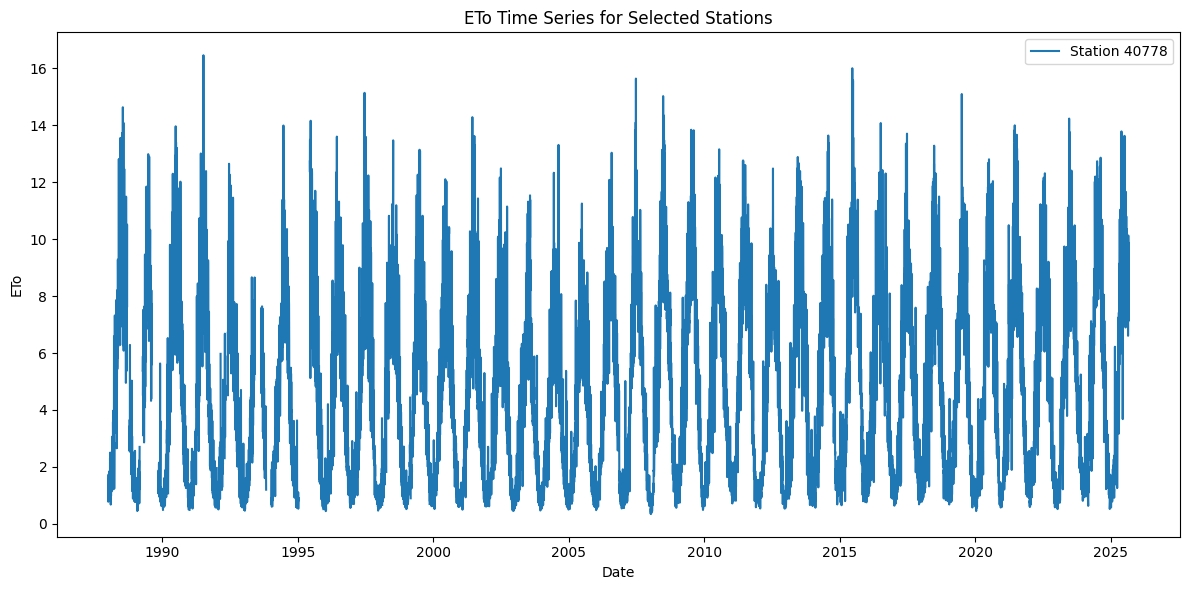

In [22]:
import matplotlib.pyplot as plt

# Select a few station_ids to plot (change as needed)
stations_to_plot = result['station_id'].drop_duplicates().sample(1)

plt.figure(figsize=(12, 6))
for sid in stations_to_plot:
    station_data = result[result['station_id'] == sid].sort_values('date')
    plt.plot(station_data['date'], station_data['FAO56'], label=f'Station {sid}')

plt.xlabel('Date')
plt.ylabel('ETo')
plt.title('ETo Time Series for Selected Stations')
plt.legend()
plt.tight_layout()
plt.show()

# Change Column Names

In [23]:
result.columns

Index(['date', 'station_id', 'station_name', 'region_id', 'region_name', 'lat',
       'lon', 'station_elevation', 'tmax', 'tmin', 'tm', 'umax', 'umin', 'um',
       'ffm', 'sshn', 'rrr24', 'FAO56', 'Hargreaves'],
      dtype='object')

In [ ]:
# result.rename(
#     columns={
#         'FAO-56': 'FAO56',
#         'Priestley-Taylor': 'PriestleyTaylor',
#         'Kimberly-Penman': 'KimberlyPenman',
#         'Thom-Oliver': 'ThomOliver',
#         'Blaney-Criddle': 'BlaneyCriddle',
#         'Jensen-Haise': 'JensenHaise',
#         'Mcguinness-Bordne': 'McguinnessBordne',
#         'FAO-24': 'FAO24',
#     }, 
#     inplace=True
# )

# Export Data

In [25]:
# To pickle in data folder
with open('../../data/Khorasan_ETo_1950_2025.pkl', 'wb') as f:
    pickle.dump(result, f)